In [1]:
import numpy as np
import pandas as pd
import re

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from tqdm.notebook import tqdm
from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def make_plot_all(objects, title, data, Q, stretch, minimum):
    for i in range(len(objects)):
        if(i%7 == 0):
            plt.figure(figsize=(12,2))
            for j in range(7):
                if(i+j > len(objects)-1): break
                plt.subplot(1,7,j+1)
                #expo = "{:e}".format(data['Average'].iloc[i+j]).split('e')[1]
                reported = 'T' if data['REPORTED'].iloc[i+j] else 'F'
                color = 'lime' if data['REPORTED'].iloc[i+j] else 'aqua'
                title = '{:.7f} {}'.format(data['Average'].iloc[i+j], reported)
                plt.title(title, color=color)
                #print(data['COADD_OBJECT_ID'].iloc[i+j]) 
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], 
                                    Q=Q, stretch=stretch, minimum=minimum)
                rgb = np.flipud(rgb)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.savefig(str(i+j) + '.png', bbox_inches='tight')
        plt.show() 

In [3]:
filepath = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/Results/fits_files/'

# Candidates above threshold
hdu_list = fits.open(filepath + 'candidates_experts.fits')
images_cand = hdu_list[1].data
data_cand = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
print(len(data_cand))

# Additional candidates
hdu_list = fits.open(filepath + 'additional.fits')
images_addi = hdu_list[1].data
data_addi = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
print(len(data_addi))

# Random candidates below the threshold
hdu_list = fits.open(filepath + 'random.fits')
images_rand = hdu_list[1].data
data_rand = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
print(len(data_rand))

images = np.concatenate((images_cand, images_addi, images_rand)).astype(np.float32)
data = pd.concat([data_cand, data_addi, data_rand], axis=0).reset_index(drop=True)
data = data.drop_duplicates() #removing duplicates
data = data.sample(frac=1, random_state=10) #random order, 42 was the order for me

images = images[data.index]
data = data.reset_index(drop=True)
data['FILENAME'] = data['SUBJECT_ID'].apply(lambda x: f'{x}.png')

print(len(images), len(data))

2502
116
500
3106 3106


In [4]:
filepath = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/Results/For_experts/Data_experts/'
names = ['Karina', 'Michael', 'Jimena']
modified_text = [[] for _ in range(len(names))] #[[], []]

for i in range(len(names)):
    name = names[i]
    print(name)
    with open(filepath + name + '.txt', 'r') as file:
        # Read the file line by line
        for line in file:
            # Process each line as needed
            output_string = line.strip().replace(',', '.')
            output_string = re.sub(r'(?<=[^\s])\s', ',', output_string, count=2)
            output_string = re.sub(r'(?<=[^\s])\s', '', output_string, count=1)
            modified_text[i].append(output_string)
            
for i in range(len(names)):
    name = names[i]
    new_file_path = 'Data_experts/' + name + '_modified.txt'
    with open(new_file_path, 'w') as new_file:
    # Write each modified line to the new file
        for modified_line in modified_text[i]:
            new_file.write(modified_line + '\n')

Karina
Michael
Jimena


In [5]:
nam_col = ['FILENAME', 'Score', 'Comment']

results = pd.DataFrame()
results['FILENAME'] = data['FILENAME']

for i in range(len(names)):
    name = names[i]
    data_tmp = pd.read_csv(filepath + names[i] + '_modified.txt', names=nam_col)
    results = pd.merge(results, data_tmp, on='FILENAME', how='left')
    results = results.rename(columns={'Score': name, 'Comment': name + '_comment'})

results['Average'] = results[names].mean(axis=1)

data = pd.merge(data, results, on='FILENAME', how='left')

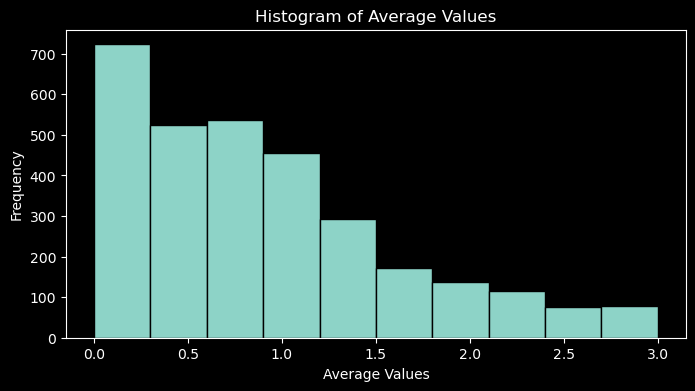

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(results['Average'], bins=10, edgecolor='black')
# Add labels and title
plt.xlabel('Average Values')
plt.ylabel('Frequency')
plt.title('Histogram of Average Values')
# Show the plot
plt.show()

960
209
1322
1287


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


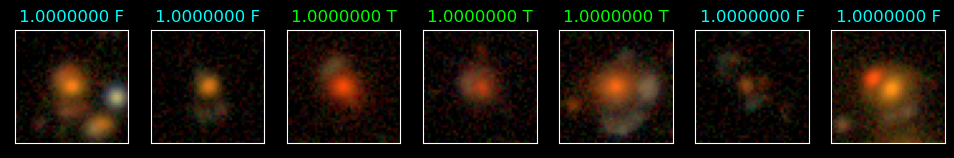

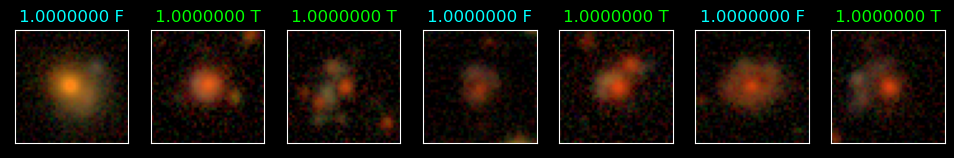

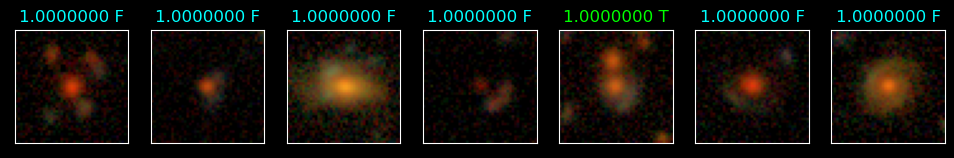

In [7]:
threshold = 1.

print(len(data[data['REPORTED'] == True]))
print(len(data[data['REPORTED'] == True][data['Average'] < threshold]))
print(len(data[data['Average'] >= threshold]))

data_tmp = data[data['Average'] >= threshold].sort_values(by='Average', ascending=True)
data_tmp = data_tmp[data_tmp['Jimena'] >= 1]
print(len(data_tmp))
#data_tmp = data_tmp[data_tmp['REPORTED']==True]
images_tmp = images[data_tmp.index]
N = 21

make_plot_all(images_tmp[0:N], 'title', data_tmp.iloc[0:N], 9, 45, (0, 0, 0))

8


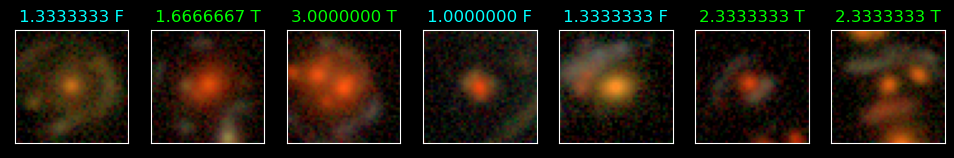

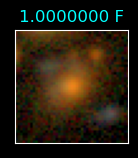

15


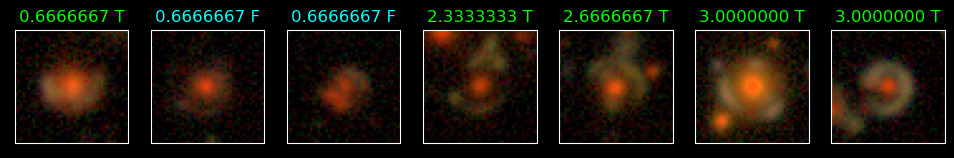

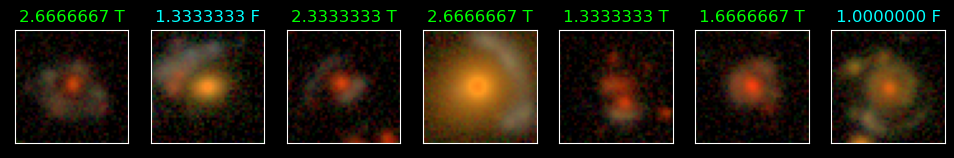

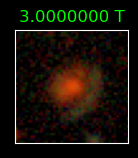

In [8]:
data_tmp = data[data['Michael_comment'].str.contains(r'\bdouble\b', case=False, na=False)]
images_tmp = images[data_tmp.index]
print(len(data_tmp))
make_plot_all(images_tmp, 'title', data_tmp, 9, 45, (0, 0, 0))

data_tmp = data[data['Jimena_comment'].str.contains(r'\bdouble\b', case=False, na=False)]
print(len(data_tmp))
images_tmp = images[data_tmp.index]
make_plot_all(images_tmp, 'title', data_tmp, 9, 45, (0, 0, 0))

39


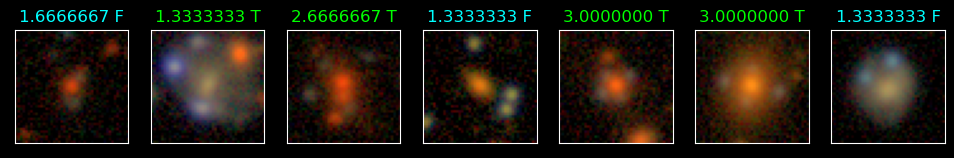

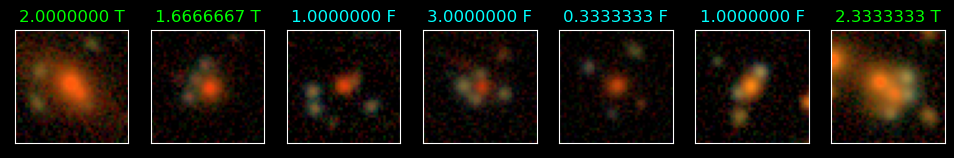

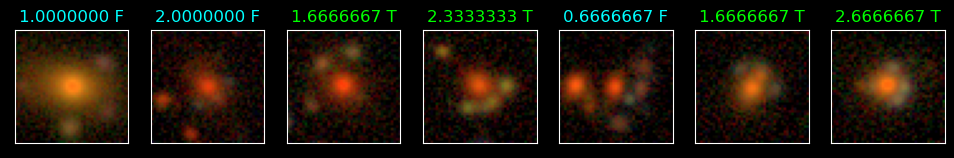

48


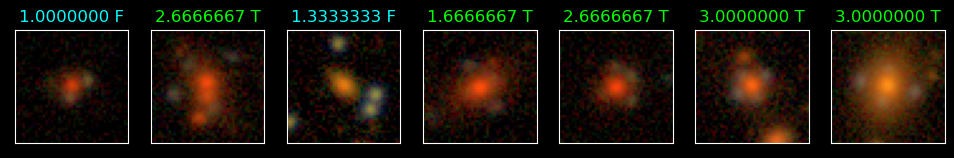

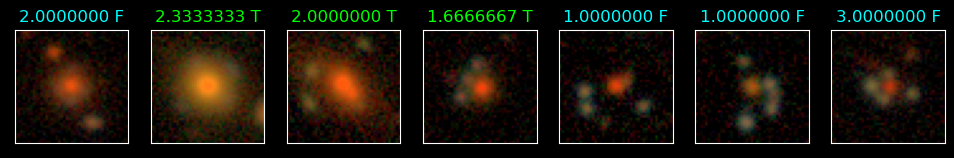

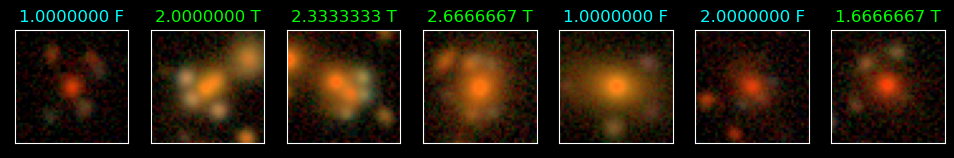

In [9]:
data_tmp = data[data['Michael_comment'].str.contains(r'\bquasar\b', case=False, na=False)]
N = 21
images_tmp = images[data_tmp.index]
print(len(data_tmp))
make_plot_all(images_tmp[0:N], 'title', data_tmp.iloc[0:N], 9, 45, (0, 0, 0))

data_tmp = data[data['Jimena_comment'].str.contains(r'\bquasar\b', case=False, na=False)]
N = 21
print(len(data_tmp))
images_tmp = images[data_tmp.index]
make_plot_all(images_tmp[0:N], 'title', data_tmp.iloc[0:N], 9, 45, (0, 0, 0))

234


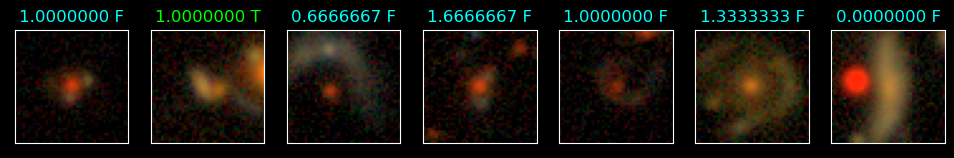

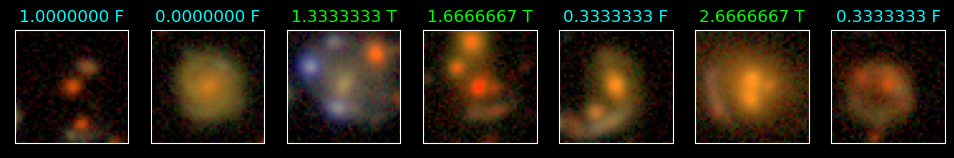

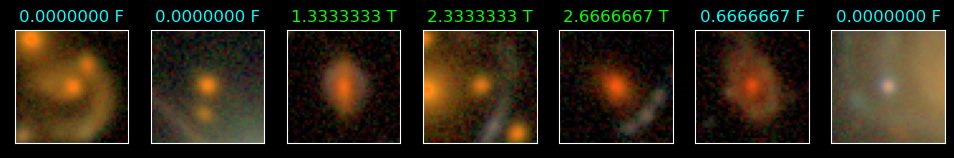

In [10]:
data_tmp = data[(data['Jimena_comment'] != 'None') | (data['Michael_comment'] != 'None') | (data['Karina_comment'] != 'None')]
images_tmp = images[data_tmp.index]
print(len(data_tmp))

make_plot_all(images_tmp[0:N], 'title', data_tmp.iloc[0:N], 9, 45, (0, 0, 0))